In [14]:
#Import Statements
#PyTorch modules

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import glob

#PIL is used to help load images
from PIL import Image

#matplotlib.pyplot will allow us to plot out our training and validation loss 
import matplotlib.pyplot as plt
#Imshow will allow us to show our images
from matplotlib.pyplot import imshow

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
from torchvision import datasets, models

Reference:
https://medium.com/nerd-for-tech/image-classification-using-transfer-learning-pytorch-resnet18-32b642148cbe

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
train_dir = "/content/drive/MyDrive/ML HW 4/Fish/train"
val_dir = "/content/drive/MyDrive/ML HW 4/Fish/val"
train_classa_dir = "/content/drive/MyDrive/ML HW 4/Fish/train/ALF"
train_classb_dir = "/content/drive/MyDrive/ML HW 4/Fish/train/NoF"
train_classc_dir = "/content/drive/MyDrive/ML HW 4/Fish/train/OTHER"
train_classd_dir = "/content/drive/MyDrive/ML HW 4/Fish/train/YTF"
val_classa_dir = "/content/drive/MyDrive/ML HW 4/Fish/val/ALB"
val_classb_dir = "/content/drive/MyDrive/ML HW 4/Fish/val/NoF"
val_classc_dir = "/content/drive/MyDrive/ML HW 4/Fish/val/OTHER"
val_classd_dir = "/content/drive/MyDrive/ML HW 4/Fish/val/YTF"


train_dataset = datasets.ImageFolder(train_dir, transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transforms_test)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

In [6]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(val_dataset))
class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 1653
Test dataset size: 232
Class names: ['ALB', 'NoF', 'OTHER', 'YFT']


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
device

device(type='cpu')

#1.1.1a1
#Fixed Feature Extractor

In [7]:
#Only fine-tuning fully connected layer
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#1.1.1a.2 
#Fine-tuning all layers

In [8]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 4) 
model = model.to(device) 
criterion = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
save_path = 'custom-classifier_resnet_18_final_60_last_tr_epochs.pth'
torch.save(model.state_dict(), save_path)

#1.1.1ac
#Resnet from Scratch

In [22]:
#Model from scratch

model_scratch = torchvision.models.resnet18(pretrained=False)



num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, 4)

model_scratch = model_scratch.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_scratch = optim.SGD(model_scratch.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#1.1.1B

#Differences in Training

I predict that of the three types of models, the most accurate will be the pre-trained ResNet that has all layers fine-tuned. This makes intuitive sense - a more trained model should have better accuracy. However, I also predict that this process will take longer to train than the others.

The fixed-feature extractor should perform relatively poorly but also might train faster.

The ResNet from scratch in theory should have the highest accuracy if allowed to train for a significant amount of time - that being said, it might not be practical to allow the model to train for this amount of time on a single GPU.

All being said, if I had more GPU cores I would likely choose the untrained ResNet but in this test case I would instead opt for the pre-trained ResNet with all layers fine-tuned.

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#1.1.2


#Training Fixed Feature Extractor

In [8]:
import time
ffe_train_loss = [] #for history 
ffe_val_loss = []
num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model_conv.train()    #(training model)
    #print("check")
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    #print("check 1")
    for i, (inputs, labels) in enumerate(train_dataloader):
        #print("check2")
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer_conv.zero_grad()
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer_conv.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    ffe_train_loss.append(epoch_loss)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    """ Testing Phase """
    model_conv.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_conv(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dataset)
        ffe_val_loss.append(epoch_loss)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Val #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #0] Loss: 1.2961 Acc: 43.4362% Time: 90.9473s
[Val #0] Loss: 1.1073 Acc: 54.3103% Time: 200.3395s
Epoch 1 running
[Train #1] Loss: 1.0739 Acc: 53.9020% Time: 230.2549s
[Val #1] Loss: 0.9771 Acc: 57.7586% Time: 234.5721s
Epoch 2 running
[Train #2] Loss: 1.0221 Acc: 58.3787% Time: 264.5013s
[Val #2] Loss: 0.9366 Acc: 60.3448% Time: 268.8104s
Epoch 3 running
[Train #3] Loss: 0.9664 Acc: 60.9800% Time: 298.5967s
[Val #3] Loss: 0.9267 Acc: 62.9310% Time: 302.8860s
Epoch 4 running
[Train #4] Loss: 0.9392 Acc: 60.9195% Time: 332.8011s
[Val #4] Loss: 0.8892 Acc: 61.6379% Time: 337.0726s
Epoch 5 running
[Train #5] Loss: 0.9064 Acc: 62.3109% Time: 366.7263s
[Val #5] Loss: 0.8876 Acc: 61.2069% Time: 371.0067s
Epoch 6 running
[Train #6] Loss: 0.8829 Acc: 63.6419% Time: 400.9143s
[Val #6] Loss: 0.8762 Acc: 61.6379% Time: 405.2682s
Epoch 7 running
[Train #7] Loss: 0.8828 Acc: 63.6419% Time: 435.2114s
[Val #7] Loss: 0.8746 Acc: 64.6552% Time: 439.5543s
Epoch 8 running
[Train #8

<function matplotlib.pyplot.show>

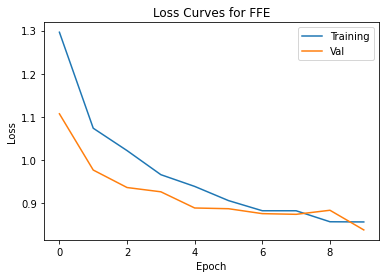

In [14]:
import matplotlib.pyplot as plt
plt.plot(ffe_train_loss, label = "Training")
plt.plot(ffe_val_loss, label = "Val")
plt.title("Loss Curves for FFE")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show


#Training Pre-Trained Model w/ All Layers

In [49]:
import time
from sklearn.metrics import f1_score
pt_train_loss = []
pt_val_loss = []
pt_preds = []
pt_labels = []
f1_scores = []
num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model.train()    #(training model)
    #print("check")
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    #print("check 1")
    for i, (inputs, labels) in enumerate(train_dataloader):
        #print("check2")
        inputs = inputs.to(device)
        labels = labels.to(device)
        pt_labels.append(labels) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        pt_preds.append(preds)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    pt_train_loss.append(epoch_loss)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    """ Testing Phase """
    model.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            f1_scores.append(f1_score(labels.data.cpu(), preds.cpu(), average = "weighted"))
        epoch_loss = running_loss / len(val_dataset)
        pt_val_loss.append(epoch_loss)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Val #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #0] Loss: 0.1870 Acc: 93.1639% Time: 31.1291s
[Val #0] Loss: 0.4175 Acc: 87.0690% Time: 35.4384s
Epoch 1 running
[Train #1] Loss: 0.1836 Acc: 93.4059% Time: 66.5925s
[Val #1] Loss: 0.3522 Acc: 90.0862% Time: 70.9379s
Epoch 2 running
[Train #2] Loss: 0.1521 Acc: 94.3739% Time: 105.8724s
[Val #2] Loss: 0.3490 Acc: 90.9483% Time: 110.1309s
Epoch 3 running
[Train #3] Loss: 0.1730 Acc: 93.6479% Time: 141.5107s
[Val #3] Loss: 0.3533 Acc: 88.7931% Time: 145.8618s
Epoch 4 running
[Train #4] Loss: 0.1626 Acc: 93.8294% Time: 177.2016s
[Val #4] Loss: 0.3163 Acc: 90.5172% Time: 181.5256s
Epoch 5 running
[Train #5] Loss: 0.1546 Acc: 94.5554% Time: 212.7558s
[Val #5] Loss: 0.3713 Acc: 87.9310% Time: 217.0842s
Epoch 6 running
[Train #6] Loss: 0.1474 Acc: 94.4949% Time: 248.3761s
[Val #6] Loss: 0.3869 Acc: 87.5000% Time: 252.6889s
Epoch 7 running
[Train #7] Loss: 0.1390 Acc: 95.1603% Time: 284.0196s
[Val #7] Loss: 0.3618 Acc: 90.0862% Time: 288.3058s
Epoch 8 running
[Train #8] L

<function matplotlib.pyplot.show>

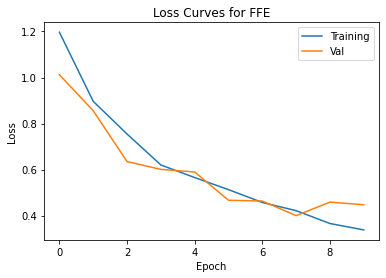

In [19]:
import matplotlib.pyplot as plt
plt.plot(pt_train_loss, label = "Training")
plt.plot(pt_val_loss, label = "Val")
plt.title("Loss Curves for FFE")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show

#Training Model from Scratch

In [23]:
import time
scratch_train_loss = []
scratch_val_loss = []
num_epochs = 10   #(set no of epochs)
start_time = time.time() #(for showing time)
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    model_scratch.train()    #(training model)
    #print("check")
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    #print("check 1")
    for i, (inputs, labels) in enumerate(train_dataloader):
        #print("check2")
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer_scratch.zero_grad()
        outputs = model_scratch(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer_scratch.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    scratch_train_loss.append(epoch_loss)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))
    
    """ Testing Phase """
    model_scratch.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_scratch(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dataset)
        scratch_val_loss.append(epoch_loss)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Val #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #0] Loss: 1.3116 Acc: 37.0841% Time: 33.5999s
[Val #0] Loss: 1.2729 Acc: 40.9483% Time: 37.9349s
Epoch 1 running
[Train #1] Loss: 1.2691 Acc: 40.2904% Time: 70.6907s
[Val #1] Loss: 1.2511 Acc: 43.9655% Time: 75.0064s
Epoch 2 running
[Train #2] Loss: 1.2506 Acc: 41.8028% Time: 106.2862s
[Val #2] Loss: 1.3149 Acc: 37.0690% Time: 110.5181s
Epoch 3 running
[Train #3] Loss: 1.2394 Acc: 42.2868% Time: 141.8987s
[Val #3] Loss: 1.2214 Acc: 43.5345% Time: 146.1870s
Epoch 4 running
[Train #4] Loss: 1.2341 Acc: 43.3757% Time: 177.2541s
[Val #4] Loss: 1.2497 Acc: 43.5345% Time: 181.5357s
Epoch 5 running
[Train #5] Loss: 1.2269 Acc: 44.1016% Time: 212.8192s
[Val #5] Loss: 1.2259 Acc: 40.9483% Time: 217.0612s
Epoch 6 running
[Train #6] Loss: 1.2229 Acc: 45.1301% Time: 248.1896s
[Val #6] Loss: 1.2735 Acc: 40.9483% Time: 252.4864s
Epoch 7 running
[Train #7] Loss: 1.2306 Acc: 42.6497% Time: 283.7755s
[Val #7] Loss: 1.2114 Acc: 43.1034% Time: 288.0574s
Epoch 8 running
[Train #8] L

<function matplotlib.pyplot.show>

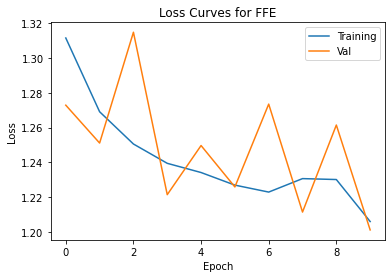

In [27]:
import matplotlib.pyplot as plt
plt.plot(scratch_train_loss, label = "Training")
plt.plot(scratch_val_loss, label = "Val")
plt.title("Loss Curves for FFE")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show

#1.2B

#Finding statistics on best model

Our best model was the fully fine-tuned model

#Confusion Matrix

Reference: https://leslietj.github.io/2020/06/22/Draw-Confusion-Matrix-for-CNN-models/

Reference: 
https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

In [37]:
nb_classes = 4

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)





tensor([[67.,  7.,  2.,  7.],
        [ 6., 40.,  0.,  0.],
        [ 2.,  0., 23.,  5.],
        [ 1.,  0.,  1., 71.]])


#Per-Class Accuracy

In [36]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))


tensor([0.8072, 0.8696, 0.7667, 0.9726])


#F1 Score

In [51]:
#gathered above, printed here for convenience
print(f1_scores[-1])

1.0


#Making Predictions on Test Set

In [10]:
 # Imports
import os
from PIL import Image
from torch.utils.data import Dataset
#from natsort import natsorted
from torchvision import datasets,transforms
from skimage import io, transform

In [33]:
class MyDataset(Dataset):
  def __init__ (self, image_paths, transform=None) :
    self.image_paths = image_paths
    self.transform = transform
    self.all_imgs = os.listdir(image_paths)

  def __getitem__(self, index) :
    img_loc = os.path.join(self.image_paths, self.all_imgs[index])
    x= Image.open(img_loc)
    if self.transform is not None:
      x=self.transform(x)
    sample = {'image': x, 'filename': self.all_imgs[index]}
    return sample
  
  def __len__(self):
    return len(self.all_imgs)



In [37]:
test_set= MyDataset("/content/drive/MyDrive/ML HW 4/Fish/test1/test", transform = transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=1)

In [38]:
len(test_set)

465

In [39]:
test_preds = []
imgs = []


with torch.no_grad():
    for i, inputs in enumerate(test_loader):
        inputs = inputs["image"].to(device)
        outputs = model(inputs)
        #classes = classes.to(device)
        #outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for j in range(inputs.size()[0]):
          test_preds.append(class_names[preds[j]])


In [42]:
import pandas as pd
pd.Series(test_preds).value_counts()

ALB      201
NoF      128
OTHER    125
YFT       11
dtype: int64

In [46]:
imgs = test_set.all_imgs
zipped = list(zip(imgs, test_preds))
final=pd.DataFrame(zipped)


In [48]:
final.to_csv("f0036rd_CNN_predictions.csv", index = False)

#Question 2

In [49]:
#packages
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
   

References:
https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout
https://towardsdatascience.com/word-embeddings-and-the-chamber-of-secrets-lstm-gru-tf-keras-de3f5c21bf16
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e

#2.1 Data Inspection

In [51]:
import pandas as pd

train = pd.read_csv("train_yelp_reviews(1).csv", sep = "\t", engine='python')

In [52]:
train
train_1 = train[train["label"]==1]
train_0 = train[train["label"]==0]

train["label"].value_counts()

from collections import Counter
print("Most common words in positive reviews")
print("***************")
print(Counter(" ".join(train_1["text"]).split()).most_common(50))
print()
print("Most common words in negative reviews")
print("*****************")
print(Counter(" ".join(train_0["text"]).split()).most_common(50))

Most common words in positive reviews
***************
[('and', 199), ('the', 186), ('was', 127), ('I', 97), ('is', 96), ('a', 95), ('The', 91), ('to', 79), ('of', 47), ('in', 44), ('this', 40), ('good', 38), ('place', 36), ('with', 35), ('for', 35), ('are', 34), ('had', 34), ('great', 34), ('very', 34), ('food', 32), ('were', 32), ('it', 32), ('have', 29), ('so', 29), ('you', 26), ('on', 24), ('This', 24), ('my', 23), ('but', 20), ('really', 19), ('service', 18), ('Great', 17), ('here', 17), ('all', 17), ('we', 17), ('time', 16), ('they', 16), ('that', 16), ('be', 16), ('good.', 15), ('friendly', 15), ('like', 15), ('our', 14), ('just', 14), ('as', 14), ('not', 13), ('also', 13), ('They', 13), ('an', 13), ('at', 12)]

Most common words in negative reviews
*****************
[('the', 172), ('I', 155), ('and', 143), ('was', 136), ('to', 118), ('a', 109), ('not', 81), ('The', 74), ('of', 66), ('is', 59), ('for', 53), ('it', 43), ('this', 42), ('in', 42), ('food', 39), ('be', 38), ('that', 

In [53]:
sum(train_0["text"].str.count("good"))

20

#2.2 Model Architecture and Training

In [54]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

frozenset({'per', 'un', 'behind', 'after', 'seems', 'your', 'a', 'ltd', 'elsewhere', 'first', 'perhaps', 'they', 'many', 'sixty', 'of', 'system', 'inc', 'de', 'him', 'sincere', 'still', 'describe', 'eight', 'these', 'few', 'too', 'very', 'since', 'thru', 'and', 'himself', 'over', 'besides', 'may', 'seemed', 'six', 'which', 'part', 'rather', 'afterwards', 'somewhere', 'noone', 'together', 'now', 'anyhow', 'then', 'had', 'onto', 'call', 'cry', 'herself', 'into', 'some', 'twenty', 'own', 'ie', 'nobody', 'ours', 'has', 'full', 'to', 'nevertheless', 'interest', 'yourself', 'well', 'front', 'even', 'upon', 'do', 'either', 'thence', 'alone', 'an', 'i', 'except', 'wherever', 'fifteen', 'thereby', 'empty', 'down', 'ourselves', 'such', 'find', 'whether', 'but', 'former', 'amoungst', 'because', 'however', 'bill', 'cannot', 'themselves', 'could', 'hundred', 'through', 'for', 'etc', 'other', 'herein', 'go', 'wherein', 'third', 'next', 'in', 'already', 'from', 'mill', 'them', 'latterly', 'name', 'be

In [55]:
#TEXT PREPROCESSING
import regex as re
replace_w_space = re.compile('[/(){}\[\]\|@,;]')
remove_symbols = re.compile('[^0-9a-z #+_]')

def text_cleaner(text):
    '''
    Takes as input a string
    
    Returns cleaned string (lowercase, no digits, no symbols)
    
    '''
    text=text.lower()
    text = replace_w_space.sub(' ', text) #replaces these with spaces
    text = remove_symbols.sub('', text) #removes these digits and other symbols
    
    return text

train['text'] = train["text"].apply(text_cleaner)

In [56]:
def remove_stopwords(text):
    words = [word for word in text.split() if word.lower() not in ENGLISH_STOP_WORDS]
    new_text = " ".join(words)
    return new_text

train["text"] = train["text"].apply(remove_stopwords)

In [57]:
train["text"] #perfect

0                  great time family dinner sunday night
1                   classic maine lobster roll fantastic
2                                             wont going
3                                       say food amazing
4                     food good service good prices good
                             ...                        
895                   guess maybe went night disgraceful
896                      restaurant atmosphere exquisite
897    sure order dessert need pack togo tiramisu can...
898    serve just vinaigrette make better overall dis...
899                                  strawberry tea good
Name: text, Length: 900, dtype: object

In [58]:
#tokenizing
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(train["text"])

words_to_index = tokenizer.word_index
print('Found %s unique tokens.' % len(words_to_index))

Found 1752 unique tokens.


In [59]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(train['text'].values)
X = pad_sequences(X, maxlen=50)
print('Shape of data tensor:', X.shape)

Y = train["label"]
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (900, 50)
Shape of label tensor: (900,)


In [60]:
#train-test-split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(720, 50) (720,)
(180, 50) (180,)


In [61]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [62]:
model = Sequential()
model.add(Embedding(1500, 50, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
#model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 12
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, verbose = 1)])

Epoch 1/12
11/11 [==============================] - 5s 131ms/step - loss: 0.6934 - accuracy: 0.4954 - val_loss: 0.6903 - val_accuracy: 0.5556
Epoch 2/12
11/11 [==============================] - 1s 86ms/step - loss: 0.6882 - accuracy: 0.6821 - val_loss: 0.6891 - val_accuracy: 0.6111
Epoch 3/12
11/11 [==============================] - 1s 95ms/step - loss: 0.6797 - accuracy: 0.8102 - val_loss: 0.6820 - val_accuracy: 0.7500
Epoch 4/12
11/11 [==============================] - 1s 89ms/step - loss: 0.6607 - accuracy: 0.8565 - val_loss: 0.6703 - val_accuracy: 0.6806
Epoch 5/12
11/11 [==============================] - 1s 89ms/step - loss: 0.6175 - accuracy: 0.8981 - val_loss: 0.6316 - val_accuracy: 0.7917
Epoch 6/12
11/11 [==============================] - 1s 97ms/step - loss: 0.5441 - accuracy: 0.8657 - val_loss: 0.5774 - val_accuracy: 0.8056
Epoch 7/12
11/11 [==============================] - 1s 87ms/step - loss: 0.4353 - accuracy: 0.9244 - val_loss: 0.5079 - val_accuracy: 0.8194
Epoch 8/12
1

In [63]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6/6 [==============================] - 0s 12ms/step - loss: 0.5987 - accuracy: 0.7389
Test set
  Loss: 0.599
  Accuracy: 0.739


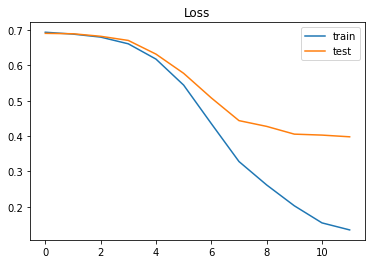

In [64]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

#Predictions

In [ ]:
test_yelp = pd.read_csv("Downloads/test_yelp_reviews.csv", sep = "\t", engine = "python")

test_yelp.head()

In [ ]:
#preprocessing
test_yelp['text'] = test_yelp["text"].apply(text_cleaner)
test_yelp["text"] = test_yelp["text"].apply(remove_stopwords)
test_yelp.head()

In [ ]:
#tokenizing
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(test_yelp["text"])

words_to_index = tokenizer.word_index
print('Found %s unique tokens.' % len(words_to_index))

In [ ]:
X = tokenizer.texts_to_sequences(test_yelp['text'].values)
X = pad_sequences(X, maxlen=50)
print('Shape of data tensor:', X.shape)

In [ ]:
y_pred = model.predict(X)
y_pred = y_pred.tolist()

In [ ]:
preds = []
for i in range(len(y_pred)):
    preds.append(y_pred[i][0])

In [ ]:
pred_labels = [1 if x>0.5 else 0 for x in preds]
pred_labels

In [ ]:
import csv
with open('f0036rd_LSTM_predictions.csv', 'w', newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ' ')
    my_writer.writerow(pred_labels)